# Importing packages

In [1]:
from workers import MasterNode
from models import LinReg, LogReg, LogRegNoncvx, NN_1d_regression
from utils import read_run, get_alg, create_plot_dir, PLOT_PATH
from sklearn.datasets import dump_svmlight_file

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from prep_data import number_of_features
import math
import torch

from numpy.random import default_rng
from numpy import linalg as la
from prep_data import DATASET_PATH
import copy
import sys
import pickle

# Customizing Matplotlib

In [2]:
plt.style.use('fast')
mpl.rcParams['mathtext.fontset'] = 'cm'
# mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'

In [3]:
markers = ['x', '.', '+', '1', 'p','*', 'D' , '>',  's', '^', 'v']

# Experiments

## 1. Comparing CGD with GD in terms of communication rounds

In [4]:
datasets = ['w6a', 'ijcnn1.bz2', 'splice']

In [15]:
alphas = [1.0, 0.1, 0.01, 0.001]
n_workers = 8
exp_name = 'cvx_comm_rounds'
max_it = 20000

alg = LogReg
logreg = True

In [16]:
regularization = 0
tolerance = 1e-3

In [17]:
std_out = sys.stdout
with open('cgd_output_all.txt', 'w') as f:
    sys.stdout = f
    for dataset_name in datasets:
        model = MasterNode(
            n_workers, 
            0.1, 
            alg, 
            dataset_name, 
            logreg, 
            True, 
            max_it=1, 
            regularization=regularization, 
            tolerance=tolerance
        )
        for alpha in alphas:
            d = number_of_features(dataset_name)
            k_array = np.linspace(0.2, 1.0, 5) * d
            k_array = np.array(k_array, dtype=np.int)
            k_array = np.insert(k_array, 0, 1)
            model.change_alpha(alpha, max_it)
            for k in k_array:
                ks = np.array([k] * n_workers, dtype=np.int)
                print('alpha = {} k = {} \n --------------------'.format(alpha, k))
                print('Running Compressed Gradient Descent...')
                model.run_cgd(ks, max_it, model='cvx', exp_name=exp_name)
sys.stdout = std_out

/home/gasanoe/fed_mixture_code/models.py:213: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()


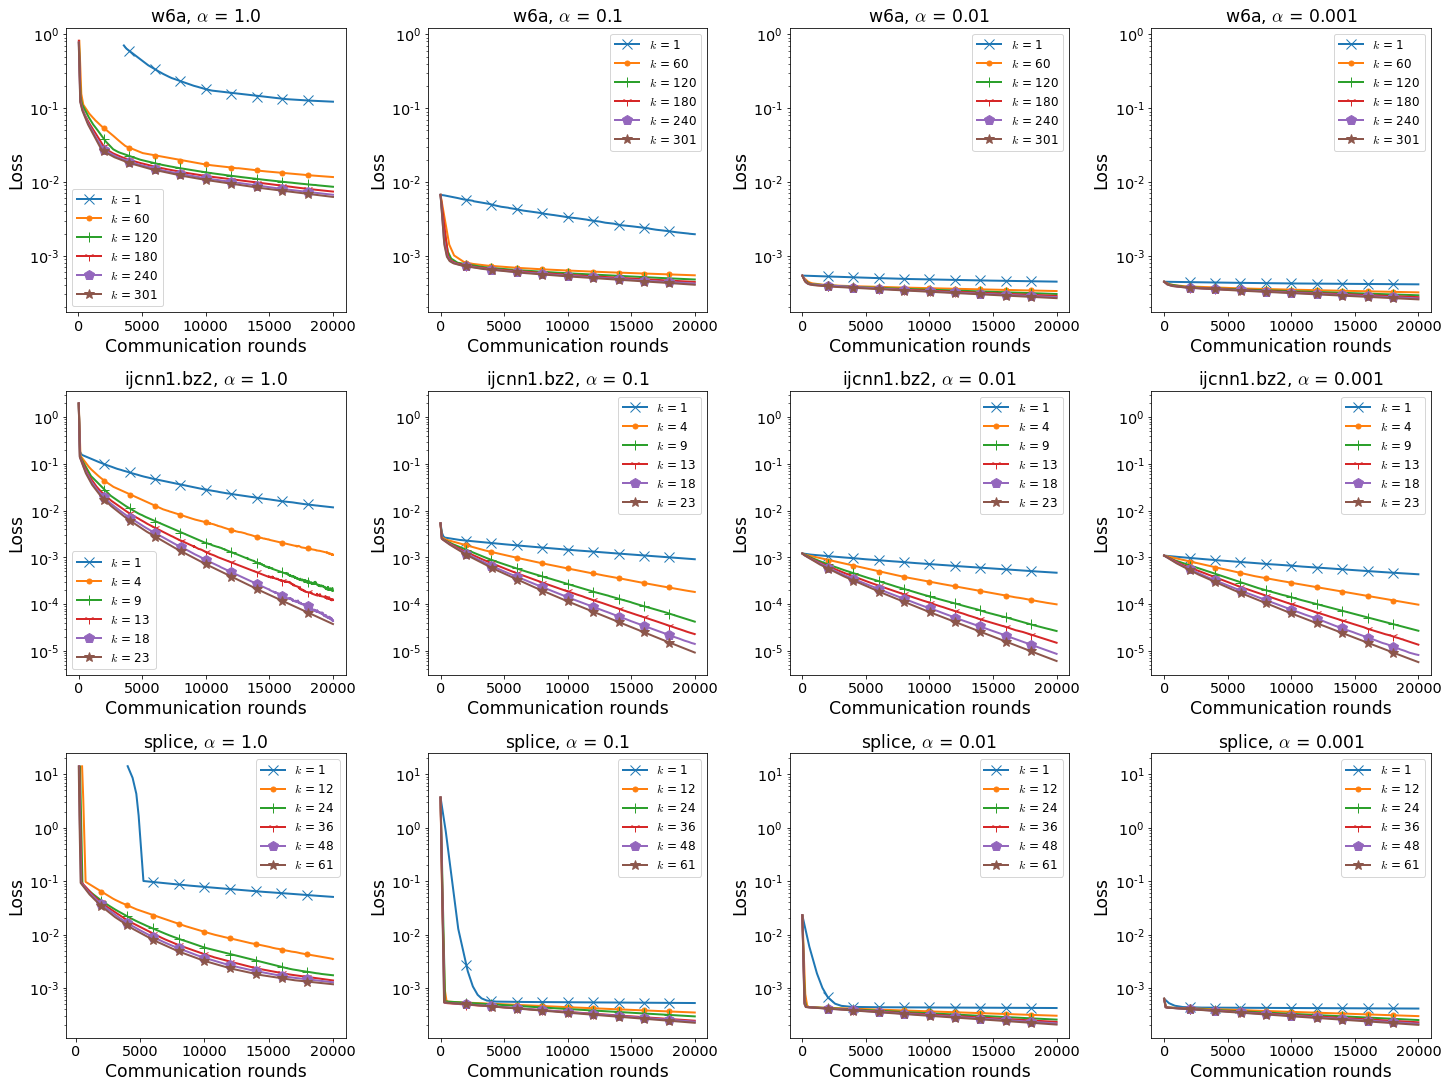

In [19]:
n_iter_shown = 20000

alphas_shown = alphas
ind_ext1 = 0
ind_ext2 = 0
ind_int = 0

fig, axs = plt.subplots(nrows=len(datasets), ncols=len(alphas_shown), sharey='row', figsize=(5 * len(alphas_shown) , 5 * len(datasets)), constrained_layout=True)

for dataset_name in datasets:
    ind_ext1 = 0
    for alpha in alphas_shown:
        ind_int = 0
        d = number_of_features(dataset_name)
        k_array = np.linspace(0.2, 1.0, 5) * d
        k_array = np.array(k_array, dtype=np.int)
        k_array = np.insert(k_array, 0, 1)
        
        k_array_shown = k_array
        
        for k in k_array_shown:    
            run = read_run('cgd' + exp_name, [alpha] * n_workers, dataset_name, logreg, [k] * n_workers)
            f_values = run['fval'][:n_iter_shown]
            
            markevery = int(f_values.size / 10)
            axs[ind_ext2, ind_ext1].plot(f_values, marker=markers[ind_int], markevery=(markevery + 2 * ind_int, markevery), markersize=10)
            ind_int += 1



        axs[ind_ext2, ind_ext1].legend([r'$k$ = {}'.format(k) for k in k_array_shown])
        axs[ind_ext2, ind_ext1].set_yscale('log')
        axs[ind_ext2, ind_ext1].set_xlabel('Communication rounds')
        axs[ind_ext2, ind_ext1].set_ylabel('Loss')
        axs[ind_ext2, ind_ext1].set_title(dataset_name + r', $\alpha$ = {}'.format(alpha) )
        axs[ind_ext2, ind_ext1].yaxis.set_tick_params(labelbottom=True)
        ind_ext1 += 1
    ind_ext2 += 1
    
alg = get_alg(logreg)
name = exp_name + '_' + alg + '_all_cvx'
create_plot_dir()
plt.savefig(PLOT_PATH + '/' + name + '.pdf')
plt.show()

## 2. Comparing CGD with GD in terms of communication cost

In [4]:
datasets = ['w6a', 'ijcnn1.bz2', 'splice']
alphas = [1.0, 0.1, 0.01, 0.001]

In [5]:
n_workers = 8
exp_name = 'cvx_comm_cost'
max_comm_cost = 800000

alg = LogReg
logreg = True
regularization = 0
tolerance = 1e-3

In [ ]:
std_out = sys.stdout
with open('cgd_output_all_comm_cost.txt', 'w') as f:
    sys.stdout = f
    for dataset_name in datasets:
        model = model = MasterNode(
            n_workers, 
            0.1, 
            alg, 
            dataset_name, 
            logreg, 
            True, 
            max_it=1, 
            regularization=regularization, 
            tolerance=tolerance
        )
        for alpha in alphas:
            d = number_of_features(dataset_name)
            k_array = np.linspace(0.2, 1.0, 5) * d
            k_array = np.array(k_array, dtype=np.int)
            k_array = np.insert(k_array, 0, 1)
            model.change_alpha(alpha, int(max_comm_cost / d))
            for k in k_array:
                max_it = int(math.ceil(max_comm_cost / (n_workers * k)))
                ks = np.array([k] * n_workers, dtype=np.int)
                print('alpha = {} k = {} \n --------------------'.format(alpha, k))
                print('Running Compressed Gradient Descent...')
                model.run_cgd(ks, max_it, model='cvx', exp_name=exp_name)
sys.stdout = std_out

/home/gasanoe/fed_mixture_code/models.py:213: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()


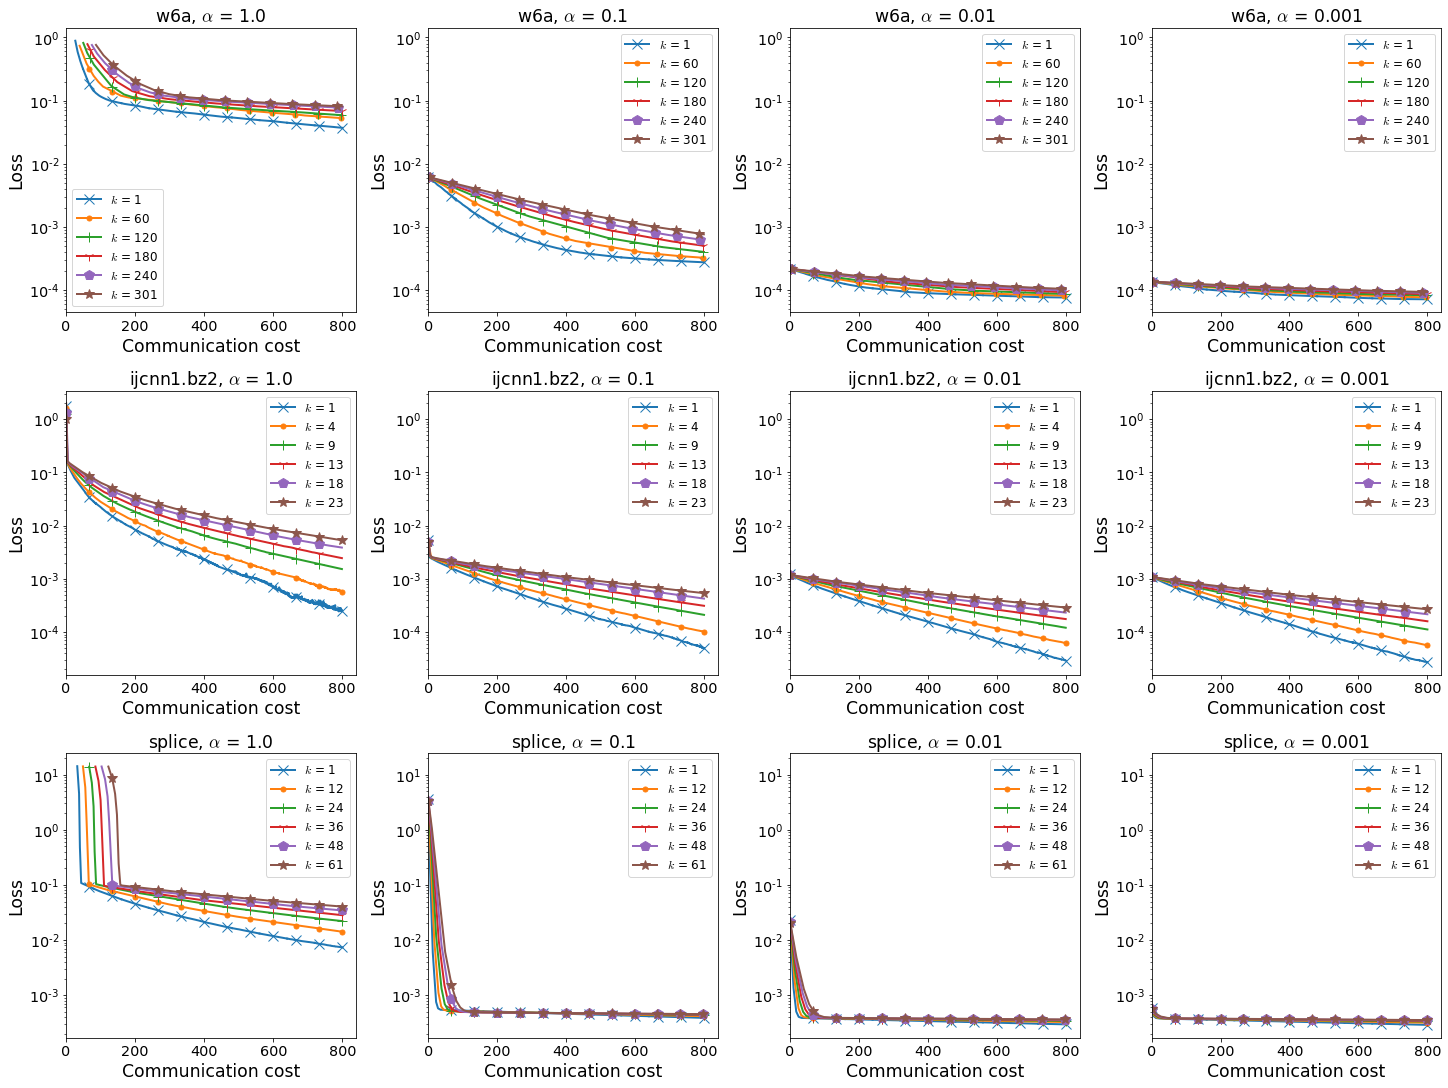

In [8]:
alphas_shown = alphas
comm_cost_shown = 800000
datasets_shown = datasets

fig, axs = plt.subplots(nrows=len(datasets_shown), ncols=len(alphas_shown), sharey='row', figsize=(5 * len(alphas) , 5 * len(datasets_shown)), constrained_layout=True)

ind_ext1 = 0
ind_ext2 = 0
ind_int = 0

n_markers_on_line = 12

for dataset_name in datasets_shown:
    ind_ext1 = 0
    for alpha in alphas_shown:
        ind_int = 0
        d = number_of_features(dataset_name)
        k_array = np.linspace(0.2, 1.0, 5) * d
        k_array = np.array(k_array, dtype=np.int)
        k_array = np.insert(k_array, 0, 1)
        
        k_array_shown = k_array
        
        for k in k_array_shown:    
            run = read_run('cgd' + exp_name, [alpha] * n_workers, dataset_name, logreg, [k] * n_workers)
            f_values = run['fval']
            f_values = f_values[f_values > 1e-9]
            comm_cost = np.array([i * k * n_workers for i in range(len(f_values))])
            
            
            f_values = f_values[comm_cost < comm_cost_shown]
            comm_cost = comm_cost[comm_cost < comm_cost_shown]
            
            
            markevery = int(len(f_values) / n_markers_on_line)

            axs[ind_ext2, ind_ext1].plot(comm_cost / 1000, f_values, marker=markers[ind_int], markevery=(2, markevery), markersize=10)
            ind_int += 1



        axs[ind_ext2, ind_ext1].legend([r'$k$ = {}'.format(k) for k in k_array_shown])
        axs[ind_ext2, ind_ext1].set_yscale('log')
        axs[ind_ext2, ind_ext1].set_xlabel('Communication cost')
        axs[ind_ext2, ind_ext1].set_xlim(left=0)
        axs[ind_ext2, ind_ext1].set_ylabel('Loss')
        # axs[ind_ext2, ind_ext1].set_ylim(bottom=1e-8)
        axs[ind_ext2, ind_ext1].set_title(dataset_name + r', $\alpha$ = {}'.format(alpha) )
        axs[ind_ext2, ind_ext1].yaxis.set_tick_params(labelbottom=True)
        ind_ext1 += 1
    ind_ext2 += 1
    
alg = get_alg(logreg)
name = exp_name + '_' + alg + '_all_comm_cost_cvx'
create_plot_dir()
plt.savefig(PLOT_PATH + '/' + name + '.pdf')
plt.show()

## 3. Comparing DIANA to GD in terms of communication rounds

In [4]:
datasets = ['w6a', 'ijcnn1.bz2', 'splice']
alphas = [1.0, 0.1, 0.01, 0.001]
n_workers = 100
exp_name = 'cvx_comm_rounds'
max_it = 3000

alg = LogReg
logreg = True

regularization = 0
tolerance = 1e-3

In [ ]:
std_out = sys.stdout
with open('diana_output_all.txt', 'w') as f:
    sys.stdout = f
    for dataset_name in datasets:
        model = model = MasterNode(
            n_workers, 
            0.1, 
            alg, 
            dataset_name, 
            logreg, 
            True, 
            max_it=1, 
            regularization=regularization, 
            tolerance=tolerance
        )
        for alpha in alphas:
            d = number_of_features(dataset_name)
            k_array = np.linspace(0.2, 1.0, 5) * d
            k_array = np.array(k_array, dtype=np.int)
            k_array = np.insert(k_array, 0, 1)
            model.change_alpha(alpha, 10 * max_it)
            for k in k_array:
                ks = np.array([k] * n_workers, dtype=np.int)
                print('alpha = {} k = {} \n --------------------'.format(alpha, k))
                print('Running DIANA...')
                model.run_diana_sparsification(ks, max_it, model='cvx', exp_name=exp_name)
            print('Running Gradient Descent...')
            model.run_gd(max_it, exp_name=exp_name)
sys.stdout = std_out

/home/gasanoe/fed_mixture_code/models.py:213: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()


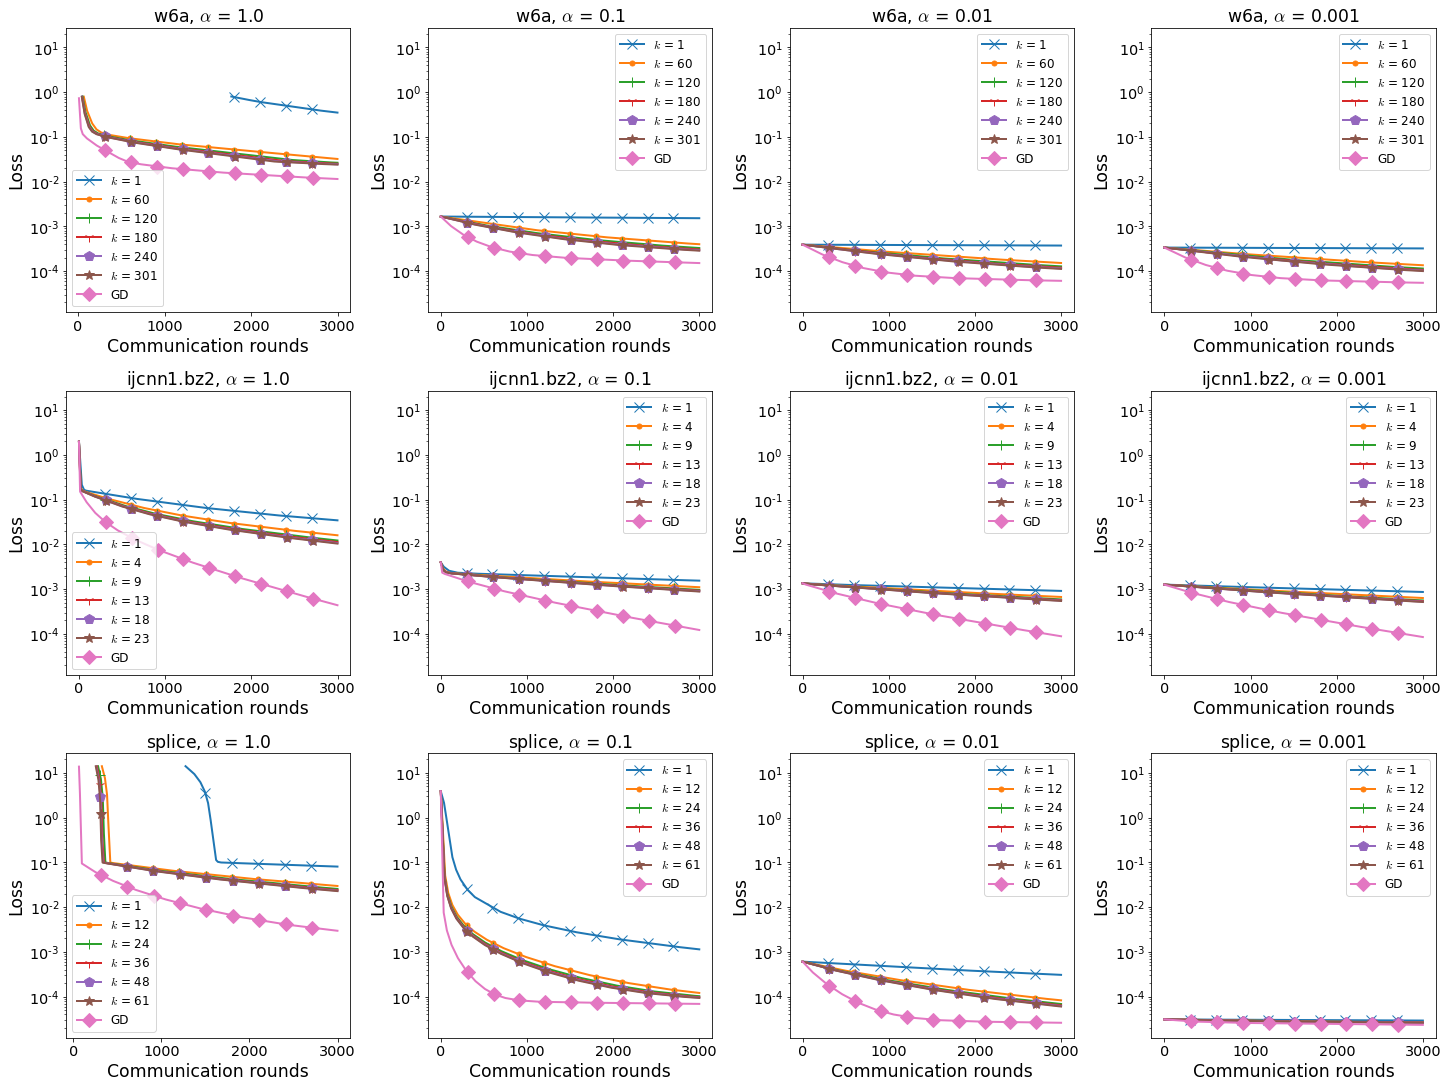

In [10]:
alphas_shown = alphas

fig, axs = plt.subplots(nrows=len(datasets), ncols=len(alphas_shown), sharey=True, figsize=(5 * len(alphas_shown) , 5 * len(datasets)), constrained_layout=True)

n_iter_shown = 3000

ind_ext1 = 0
ind_ext2 = 0
ind_int = 0

for dataset_name in datasets:
    ind_ext1 = 0
    for alpha in alphas_shown:
        ind_int = 0
        d = number_of_features(dataset_name)
        k_array = np.linspace(0.2, 1.0, 5) * d
        k_array = np.array(k_array, dtype=np.int)
        k_array = np.insert(k_array, 0, 1)
        
        k_array_shown = k_array
        
        for k in k_array_shown:    
            run = read_run('diana' + exp_name, [alpha] * n_workers, dataset_name, logreg, [k] * n_workers)
            f_values = run['fval'][:n_iter_shown]

            markevery = int(f_values.size / 10)
            axs[ind_ext2, ind_ext1].plot(f_values, marker=markers[ind_int], markevery=(markevery + 2 * ind_int, markevery), markersize=10, 
                                        label = r'$k$ = {}'.format(k))
            ind_int += 1
            
        run = read_run('gd' + exp_name, [alpha] * n_workers, dataset_name, logreg)
        f_values = run['fval'][:n_iter_shown]
        markevery = int(f_values.size / 10)
        axs[ind_ext2, ind_ext1].plot(f_values, marker=markers[ind_int], markevery=(markevery + 2 * ind_int, markevery), markersize=10, label='GD')


        axs[ind_ext2, ind_ext1].set_yscale('log')
        axs[ind_ext2, ind_ext1].set_xlabel('Communication rounds')
        axs[ind_ext2, ind_ext1].set_ylabel('Loss')
        axs[ind_ext2, ind_ext1].set_title(dataset_name + r', $\alpha$ = {}'.format(alpha) )
        axs[ind_ext2, ind_ext1].yaxis.set_tick_params(labelbottom=True)
        axs[ind_ext2, ind_ext1].legend()
        ind_ext1 += 1
    ind_ext2 += 1
    
alg = get_alg(logreg)
name = 'diana' + '_' + alg + '_all_cvx'
create_plot_dir()
plt.savefig(PLOT_PATH + '/' + name + '.pdf')
plt.show()

## 4. Comparing DIANA to GD in terms of communication cost

In [7]:
datasets = ['w6a', 'ijcnn1.bz2', 'splice']
alphas = [1.0, 0.1, 0.01, 0.001]

In [9]:
n_workers = 100
exp = 'diana_cvx_comm_cost'
max_comm_cost = 800000

alg = LogReg
logreg = True
regularization = 0
tolerance = 1e-3

In [ ]:
std_out = sys.stdout
with open('diana_output_all_comm_cost.txt', 'w') as f:
    sys.stdout = f
    for dataset_name in datasets:
        model = model = MasterNode(
            n_workers, 
            0.1, 
            alg, 
            dataset_name, 
            logreg, 
            True, 
            max_it=1, 
            regularization=regularization, 
            tolerance=tolerance
        )
        for alpha in alphas:
            d = number_of_features(dataset_name)
            k_array = np.linspace(0.2, 1.0, 5) * d
            k_array = np.array(k_array, dtype=np.int)
            k_array = np.insert(k_array, 0, 1)
            model.change_alpha(alpha, int(max_comm_cost / d))
            for k in k_array:
                max_it = int(math.ceil(max_comm_cost / (n_workers * k)))
                ks = np.array([k] * n_workers, dtype=np.int)
                print('alpha = {} k = {} \n --------------------'.format(alpha, k))
                print('Running Compressed Gradient Descent...')
                model.run_diana_sparsification(ks, max_it, model='cvx', exp_name=exp)
            model.run_gd(int(max_comm_cost / (n_workers * d)), exp_name=exp)
sys.stdout = std_out

/home/gasanoe/fed_mixture_code/models.py:213: RuntimeWarning: divide by zero encountered in log
  return -(np.where(y == 1, np.log(h), zeros) + np.where(y == 0, np.log(1-h), zeros)).mean()


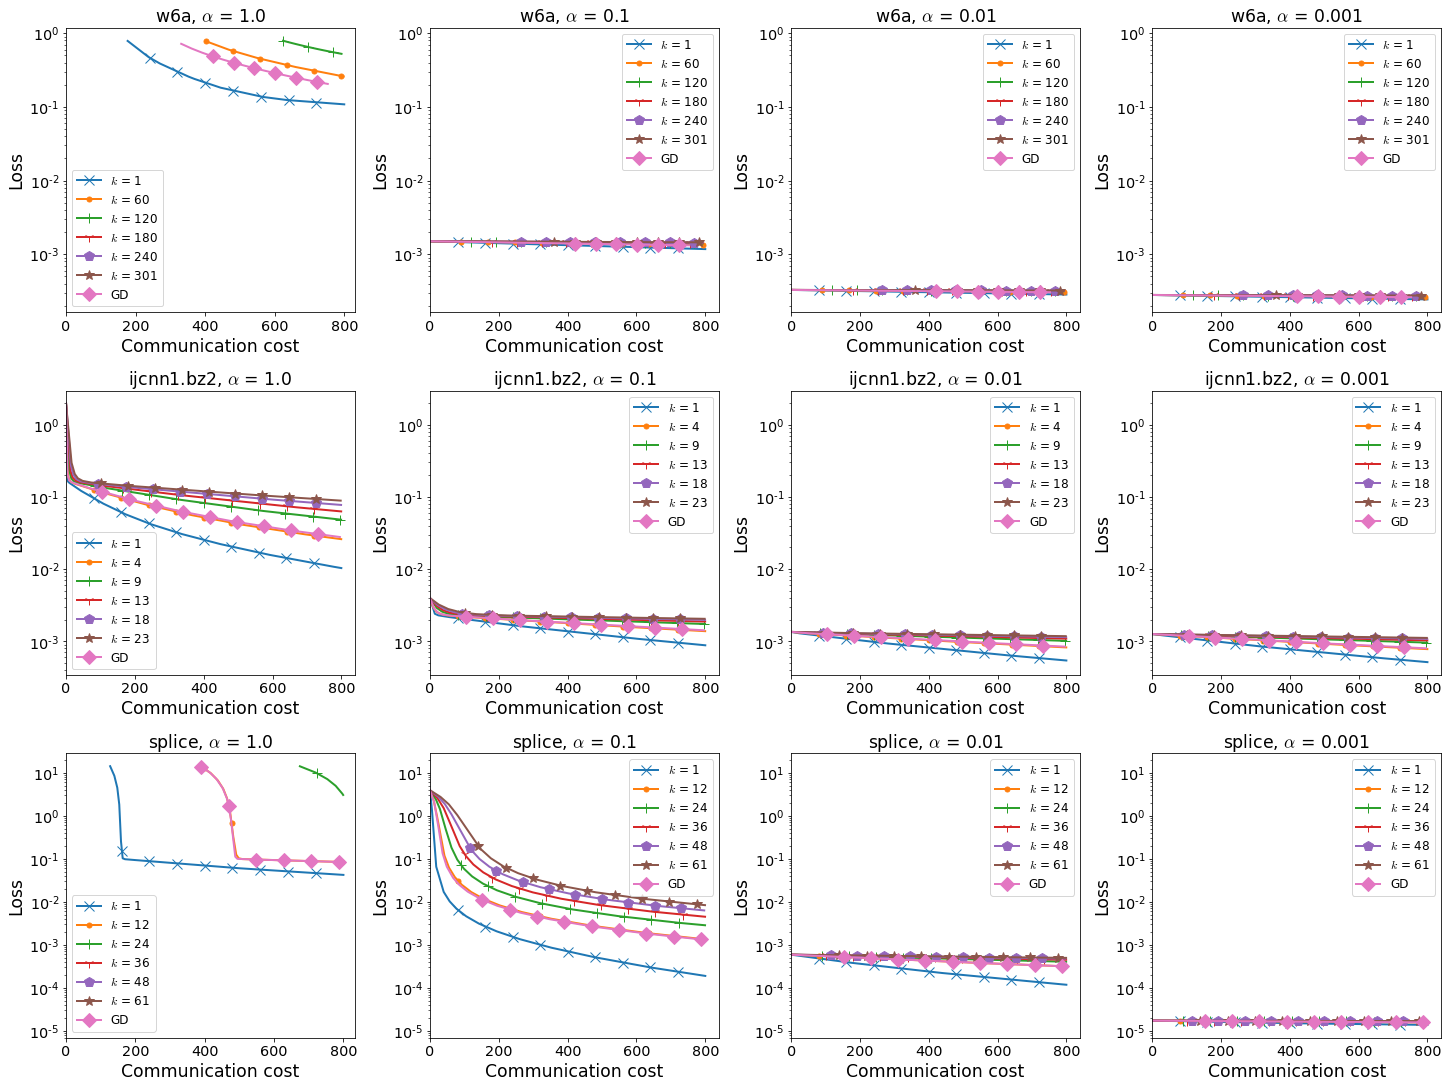

In [15]:
alphas_shown = alphas

fig, axs = plt.subplots(nrows=len(datasets), ncols=len(alphas_shown), sharey='row', figsize=(5 * len(alphas_shown) , 5 * len(datasets)), constrained_layout=True)

comm_cost_showns = {'w6a' : 800000, 'ijcnn1.bz2' : 800000, 'splice' : 800000}

ind_ext1 = 0
ind_ext2 = 0
ind_int = 0

for dataset_name in datasets:
    ind_ext1 = 0
    for alpha in alphas_shown:
        ind_int = 0
        d = number_of_features(dataset_name)
        k_array = np.linspace(0.2, 1.0, 5) * d
        k_array = np.array(k_array, dtype=np.int)
        k_array = np.insert(k_array, 0, 1)
        
        k_array_shown = k_array
        
        for k in k_array_shown:    
            run = read_run(exp, [alpha] * n_workers, dataset_name, logreg, [k] * n_workers)
            f_values = run['fval']
            comm_cost = np.array([i * k * n_workers for i in range(len(f_values))])
            
#             comm_cost = comm_cost[f_values > 1e-15]
#             f_values = f_values[f_values > 1e-15]

            comm_cost_shown = comm_cost_showns[dataset_name]
            
            
            f_values = f_values[comm_cost < comm_cost_shown]
            comm_cost = comm_cost[comm_cost < comm_cost_shown]



            markevery = max(int(f_values.size / 10), 2)
            axs[ind_ext2, ind_ext1].plot(comm_cost / 1000, f_values, marker=markers[ind_int], markevery=(markevery + 2 * ind_int, markevery), markersize=10, 
                                        label = r'$k$ = {}'.format(k))
            ind_int += 1
    
            
        run = read_run(exp, [alpha] * n_workers, dataset_name, logreg)
        f_values = run['fval']
        comm_cost = np.array([i * d * n_workers for i in range(len(f_values))])
        
        f_values = f_values[comm_cost < comm_cost_shown]
        comm_cost = comm_cost[comm_cost < comm_cost_shown]


            
#         comm_cost = comm_cost[f_values > 1e-15]
#         f_values = f_values[f_values > 1e-15]
        
        markevery = max(int(f_values.size / 10), 2)
        axs[ind_ext2, ind_ext1].plot(comm_cost / 1000, f_values, marker=markers[ind_int], markevery=(markevery + 2 * ind_int, markevery), markersize=10, label='GD')


        axs[ind_ext2, ind_ext1].set_yscale('log')
        axs[ind_ext2, ind_ext1].set_xlabel('Communication cost')
        axs[ind_ext2, ind_ext1].set_xlim(left = 0)
        axs[ind_ext2, ind_ext1].set_ylabel('Loss')
        axs[ind_ext2, ind_ext1].set_title(dataset_name + r', $\alpha$ = {}'.format(alpha) )
        axs[ind_ext2, ind_ext1].yaxis.set_tick_params(labelbottom=True)
        axs[ind_ext2, ind_ext1].legend()
        ind_ext1 += 1
    ind_ext2 += 1
    
alg = get_alg(logreg)
name = 'diana' + '_' + alg + '_all_comm_cost_cvx(n=100)'
create_plot_dir()
plt.savefig(PLOT_PATH + '/' + name + '.pdf')
plt.show()